In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
sequences_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/extracted-features/extracted-features.csv')

In [4]:
sequences_df['intensity_log'] = np.log2(sequences_df.intensity)

In [6]:
# find the experiment-wide mean of intensity
experiment_means_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    # intensity
    experiment_intensity_log_median = np.median(group_df.intensity_log)
    experiment_intensity_median = np.median(group_df.intensity)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_means_l.append((sequence,charge,experiment_intensity_median,experiment_intensity_log_median))

experiment_means_df = pd.DataFrame(experiment_means_l, columns=['sequence','charge','experiment_intensity_median','experiment_intensity_log_median'])


In [10]:
sequences_medians_df = pd.merge(sequences_df, experiment_means_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])
sequences_medians_df['delta_intensity_log'] = sequences_medians_df.intensity_log - sequences_medians_df.experiment_intensity_log_median


In [13]:
file_idx = 1

In [14]:
minimum_number_of_runs_for_training_set = 10

In [37]:
selected_run_df = sequences_medians_df[sequences_medians_df.file_idx == file_idx].copy()
selected_run_df.sort_values(by=['rt_apex'], ascending=True, inplace=True)


In [38]:
lowess = sm.nonparametric.lowess

In [39]:
zz = lowess(selected_run_df.delta_intensity_log, selected_run_df.rt_apex, frac=0.006, return_sorted=False)


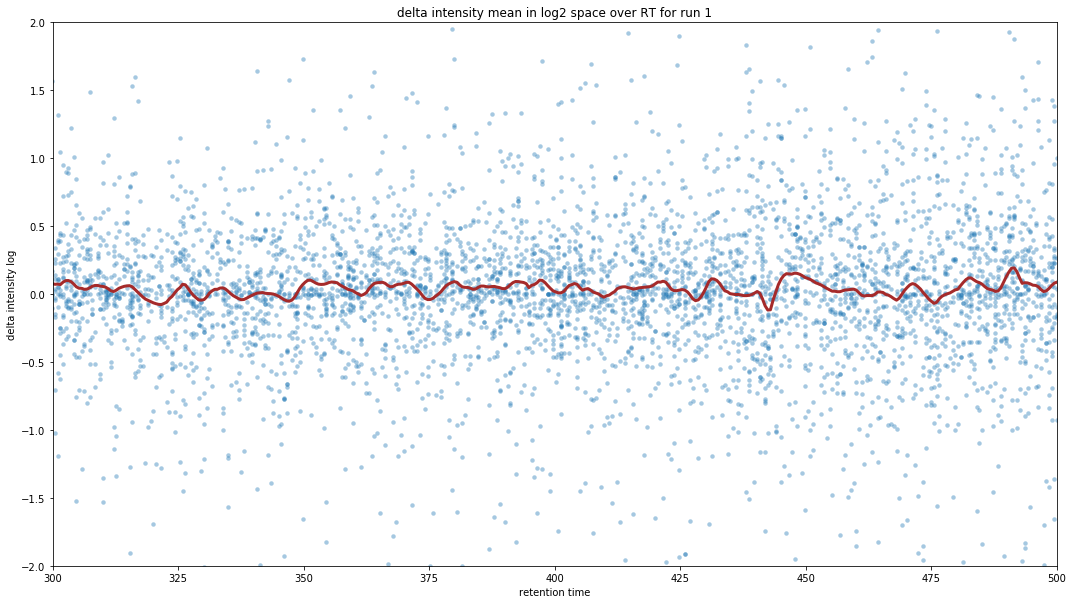

In [40]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(selected_run_df.rt_apex, selected_run_df.delta_intensity_log, marker='o', lw=0, s=20, alpha=0.4)
ax.plot(selected_run_df.rt_apex, zz, marker='', color='brown', linestyle='-', linewidth=3, ms=5, label='frac = 0.33')

# plt.legend(loc='best')
plt.ylabel('delta intensity log')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(file_idx))
plt.xlim((300,500))
plt.ylim((-2,2))

plt.show()

In [41]:
# estimate the delta intensity
selected_run_df['smoothed_delta_intensity_log'] = zz
selected_run_df['smoothed_delta_intensity'] = np.power(2, selected_run_df.smoothed_delta_intensity_log)
selected_run_df['normalised_intensity'] = selected_run_df.intensity - selected_run_df.smoothed_delta_intensity


In [42]:
selected_run_df[['sequence','charge','intensity','experiment_intensity_median','delta_intensity_log','smoothed_delta_intensity_log','smoothed_delta_intensity','normalised_intensity']].sample(5)


,sequence,charge,intensity,experiment_intensity_median,delta_intensity_log,smoothed_delta_intensity_log,smoothed_delta_intensity,normalised_intensity
199975,SWTSSSSLSDTYEPNYGTVK,2,519,383.5,0.436862,0.083329,1.059460,517.940540
184105,DIFQEIFDK,2,1883,1505.0,0.323270,-0.112206,0.925173,1882.074827
193773,LMNDMTAVALNYGIYK,2,2942,1672.5,0.816548,0.063978,1.045344,2940.954656
191933,IVDDWANDGWGLK,2,17974,20277.0,-0.173847,0.112481,1.081086,17972.918914
181849,AGGGSATLSMGQAAAR,2,61072,59847.5,0.029312,0.067541,1.047929,61070.952071
